# Analysis of data pre and post Covid 19

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype
from bokeh.io import output_file, show
from bokeh.transform import factor_cmap
from bokeh.layouts import column,row 
from bokeh.transform import jitter
from bokeh.models import CategoricalColorMapper
from bokeh.models import Div, RangeSlider, Spinner
from bokeh.models import Select
from bokeh.models import ColumnDataSource, HoverTool, CustomJS
from bokeh.plotting import figure
from bokeh.palettes import Category10
from scipy.stats import gaussian_kde


## Import data

In [192]:
# Define a helper function to load and tag each dataset by wave
def load_and_tag(filepath, wave):
    df = pd.read_sas(filepath, format='xport')
    df['wave'] = wave
    return df

# Load pre-COVID (2017–March 2020) data
vid_pre = load_and_tag("VID_J.xpt", "pre")
deq_pre = load_and_tag("DEQ_J.xpt", "pre")
diet_pre = load_and_tag("DSQIDS_J.xpt", "pre")


# Load post-COVID (2021–22) data
vid_post = load_and_tag("VID_L.XPT", "post")
deq_post = load_and_tag("DEQ_L.XPT", "post")
diet_post = load_and_tag("DSQIDS_L.xpt", "post")

# Concatenate each domain's pre and post data
vid = pd.concat([vid_pre, vid_post], ignore_index=True)
deq = pd.concat([deq_pre, deq_post], ignore_index=True)
diet = pd.concat([diet_pre, diet_post], ignore_index=True)


# Merge all on SEQN and wave
df = vid.merge(deq, on=['SEQN', 'wave'], how='outer')\
        .merge(diet, on=['SEQN', 'wave'], how='outer')

# Save to CSV for further analysis
df.to_csv("nhanes_combined_pre_post.csv", index=False)

print("Combined dataset shape:", df.shape)

Combined dataset shape: (31328, 107)


## Analysis

In [193]:
vitamin_d_sun = df[['SEQN','wave', 'LBXVIDMS', 'DEQ034A', 'DEQ034C', 'DEQ034D']].dropna()
vitamin_d_sun.to_csv("vitamin_d_sun_19.csv", index=False)

### Vitamin D distribution pre and post Covid

In [194]:
df_vit = vitamin_d_sun[['SEQN','wave', 'LBXVIDMS']].dropna()

def get_boxplot_stats(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    data_filtered = data[(data >= lower) & (data <= upper)]
    return {
        'q1': q1,
        'q2': data_filtered.median(),
        'q3': q3,
        'lower': data_filtered.min(),
        'upper': data_filtered.max()
    }

# Get box plot data for each wave
data_dict = {}
for wave_label in ['all', 'pre', 'post']:
    if wave_label == 'all':
        data_wave = df_vit['LBXVIDMS']
    else:
        data_wave = df_vit[df_vit['wave'] == wave_label]['LBXVIDMS']
    stats = get_boxplot_stats(data_wave)
    data_dict[wave_label] = {
        'wave': [wave_label],
        'q1': [stats['q1']],
        'q2': [stats['q2']],
        'q3': [stats['q3']],
        'lower': [stats['lower']],
        'upper': [stats['upper']]
    }

# Create full ColumnDataSource with all three options
source = ColumnDataSource(data=data_dict['all'])

# Box plot setup
p = figure(title="Box Plot of Vitamin D Levels", x_range=(-1,1), y_axis_label="Vitamin D (nmol/L)", width=600, height=400)

# Whiskers
p.segment(x0=0, y0='upper', x1=0, y1='q3', source=source, line_width=2)
p.segment(x0=0, y0='lower', x1=0, y1='q1', source=source, line_width=2)

# Boxes
p.vbar(x=0, width=0.3, bottom='q1', top='q3', source=source, fill_color=Category10[3][1])

# Median line
p.segment(x0=-0.15, y0='q2', x1=0.15, y1='q2', source=source, line_color='black', line_width=3)

# Hover tool (show stats)
p.add_tools(HoverTool(tooltips=[
    ("Lower", "@lower"),
    ("Q1", "@q1"),
    ("Median", "@q2"),
    ("Q3", "@q3"),
    ("Upper", "@upper")
]))

# Dropdown to filter wave
select = Select(title="Select Period:", value="all", options=["all", "pre", "post"])

# Callback
callback = CustomJS(args=dict(source=source, full_data=data_dict, select=select), code="""
    const wave = select.value;
    const new_data = full_data[wave];
    for (let key in new_data) {
        source.data[key] = new_data[key];
    }
    source.change.emit();
""")

select.js_on_change('value', callback)

# Show output
output_file("vitamin_d_boxplot_filtered.html")
show(column(select, p))


In [195]:
# Split by pre - post covid
df_pre = vitamin_d_sun[vitamin_d_sun['wave'] == 'pre']
df_post = vitamin_d_sun[vitamin_d_sun['wave'] == 'post']

# Define a function to calculate basic stats
def vitamin_d_stats(data, label):
    stats = {
        'Wave': label,
        'Count': data['LBXVIDMS'].count(),
        'Mean': data['LBXVIDMS'].mean(),
        'Median': data['LBXVIDMS'].median(),
        'Standard Deviation': data['LBXVIDMS'].std(),
        'Min': data['LBXVIDMS'].min(),
        'Max': data['LBXVIDMS'].max(),
        '25th Percentile': data['LBXVIDMS'].quantile(0.25),
        '75th Percentile': data['LBXVIDMS'].quantile(0.75)
    }
    return stats

# Calculate stats
stats_pre = vitamin_d_stats(df_pre, 'Pre-COVID')
stats_post = vitamin_d_stats(df_post, 'Post-COVID')

# Combine and display
stats_df = pd.DataFrame([stats_pre, stats_post])
stats_df

,Wave,Count,Mean,Median,Standard Deviation,Min,Max,25th Percentile,75th Percentile
0,Pre-COVID,4981,68.835607,65.6,29.631354,9.96,224.0,48.2,84.7
1,Post-COVID,5215,82.739430,77.0,38.173293,9.13,285.0,57.0,104.0


In [196]:
# Outlier removal using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]


In [197]:
# Apply outlier removal
df_vit = remove_outliers(df_vit, 'LBXVIDMS')

#df_pre = remove_outliers(df_pre, 'LBXVIDMS')
#df_post = remove_outliers(df_post, 'LBXVIDMS')

# Bin edges
bins = list(range(0, int(df_vit['LBXVIDMS'].max()) + 10, 5))
bin_labels = pd.IntervalIndex.from_breaks(bins)

# Count histograms for each wave
hist_all = pd.cut(df_vit['LBXVIDMS'], bins=bins).value_counts().sort_index()
hist_pre = pd.cut(df_vit[df_vit['wave'] == 'pre']['LBXVIDMS'], bins=bins).value_counts().sort_index()
hist_post = pd.cut(df_vit[df_vit['wave'] == 'post']['LBXVIDMS'], bins=bins).value_counts().sort_index()

# Prepare data for JavaScript
data = {
    'left': [i.left for i in hist_all.index],
    'right': [i.right for i in hist_all.index],
    'all': hist_all.values,
    'pre': hist_pre.values,
    'post': hist_post.values,
}

source = ColumnDataSource(data=dict(
    left=data['left'],
    right=data['right'],
    top=data['all'],  # default view
))


# KDE for all
kde_all = gaussian_kde(df_vit['LBXVIDMS'])
x_kde_all = np.linspace(df_vit['LBXVIDMS'].min(), df_vit['LBXVIDMS'].max(), 200)
y_kde_all = kde_all(x_kde_all) * len(df_vit) * (bins[1] - bins[0])

# KDE for pre
df_vit_pre = df_vit[df_vit['wave'] == 'pre']
kde_pre = gaussian_kde(df_vit_pre['LBXVIDMS'])
y_kde_pre = kde_pre(x_kde_all) * len(df_vit_pre) * (bins[1] - bins[0])

# KDE for post
df_vit_post = df_vit[df_vit['wave'] == 'post']
kde_post = gaussian_kde(df_vit_post['LBXVIDMS'])
y_kde_post = kde_post(x_kde_all) * len(df_vit_post) * (bins[1] - bins[0])

# Store KDE data for switching in JS
kde_data = {
    'x': x_kde_all.tolist(),
    'all': y_kde_all.tolist(),
    'pre': y_kde_pre.tolist(),
    'post': y_kde_post.tolist(),
}
source_kde = ColumnDataSource(data=dict(x=kde_data['x'], y=kde_data['all']))

# Create plot
p = figure(title="Vitamin D Distribution", x_axis_label="Vitamin D (nmol/L)", y_axis_label="Frequency", width=800, height=400)
quad = p.quad(top='top', bottom=0, left='left', right='right', source=source, 
              fill_color='lightblue', line_color="white")
p.add_tools(HoverTool(tooltips=[("Range", "@left - @right"), ("Count", "@top")]))
p.line('x', 'y', source=source_kde, line_width=2, line_color="red", legend_label="KDE Fit")

# Dropdown filter
select = Select(title="Select Wave:", value="All", options=["All", "pre", "post"])

# Add JavaScript callback
callback = CustomJS(args=dict(source=source, source_kde=source_kde, full_data=data, kde_data=kde_data, select=select), code="""
    const f = select.value.toLowerCase();
    source.data.top = full_data[f];
    source_kde.data.y = kde_data[f];
    source.change.emit();
    source_kde.change.emit();
""")

select.js_on_change('value', callback)

# Show plot
output_file("vitamin_d_distribution_filtered.html")
show(column(select, p))


In [198]:
def summarize_kde(label, data, kde_func, x_kde):
    print(f"\nSummary for {label}:")
    print(f"  Count: {len(data)}")
    print(f"  Mean: {np.mean(data):.2f}")
    print(f"  Std Dev: {np.std(data):.2f}")
    print(f"  KDE Peak Location (mode estimate): {x_kde[np.argmax(kde_func(x_kde))]:.2f}")
    print(f"  5th percentile: {np.percentile(data, 5):.2f}")
    print(f"  95th percentile: {np.percentile(data, 95):.2f}")

# Print summaries
summarize_kde("All", df_vit['LBXVIDMS'], kde_all, x_kde_all)
summarize_kde("Pre-COVID", df_vit_pre['LBXVIDMS'], kde_pre, x_kde_all)
summarize_kde("Post-COVID", df_vit_post['LBXVIDMS'], kde_post, x_kde_all)



Summary for All:
  Count: 9909
  Mean: 72.82
  Std Dev: 29.81
  KDE Peak Location (mode estimate): 69.65
  5th percentile: 27.40
  95th percentile: 130.00

Summary for Pre-COVID:
  Count: 4913
  Mean: 67.39
  Std Dev: 27.07
  KDE Peak Location (mode estimate): 63.74
  5th percentile: 26.60
  95th percentile: 115.00

Summary for Post-COVID:
  Count: 4996
  Mean: 78.17
  Std Dev: 31.38
  KDE Peak Location (mode estimate): 71.13
  5th percentile: 29.18
  95th percentile: 136.00


### Questions: How do sun-protective behaviors (e.g., staying in the shade, wearing long sleeves, using sunscreen) influence serum vitamin D levels pre and post pandemic?
Variables:
- LBXVIDMS: Total serum 25-hydroxyvitamin D
- DEQ034A: Frequency of staying in shade
- DEQ034C: Frequency of wearing long sleeves
- DEQ034D: Frequency of using sunscreen

Objective: 
- Understand if more frequent sun-avoidance behavior (e.g., staying in shade, using sunscreen) is associated with lower vitamin D levels.

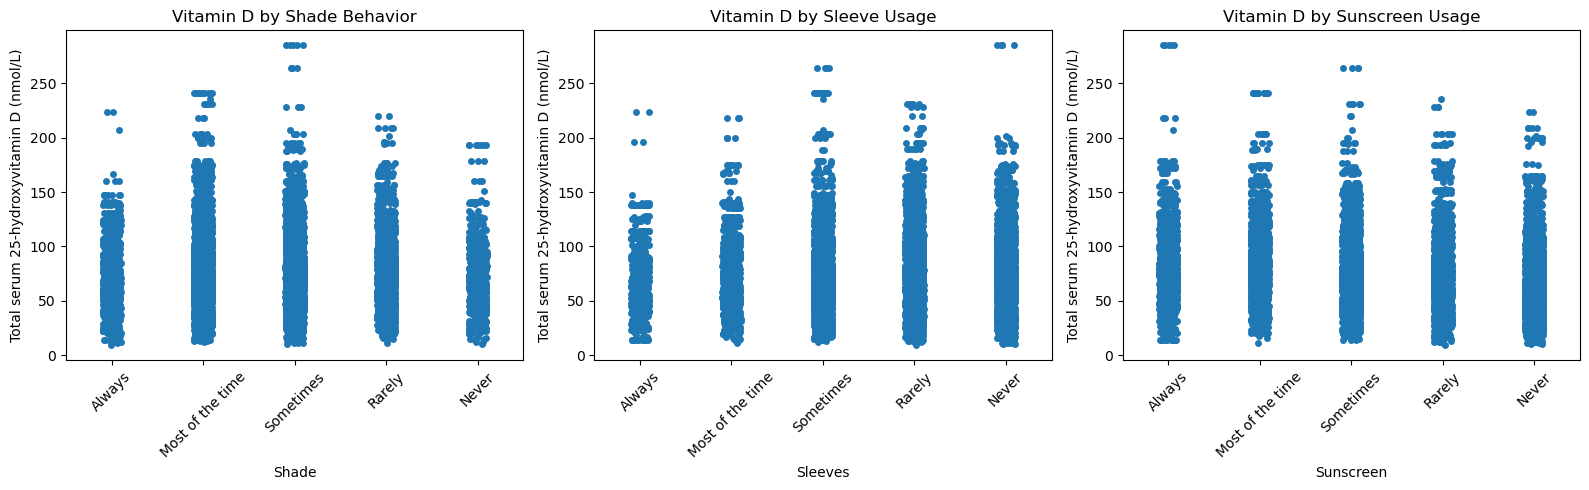

In [199]:
# Map sun protection variables from categorical codes to meaningful ordinal values
sun_protection_map = {
    1: 'Always',
    2: 'Most of the time',
    3: 'Sometimes',
    4: 'Rarely',
    5: 'Never',
    7: 'Refused',
    9: 'Don’t know'
}

# Valid responses only (for filtering and ordering)
valid_responses = ['Always', 'Most of the time', 'Sometimes', 'Rarely', 'Never']
response_dtype = CategoricalDtype(categories=valid_responses, ordered=True)

# Apply mapping
vitamin_d_sun['Shade'] = vitamin_d_sun['DEQ034A'].map(sun_protection_map)
vitamin_d_sun['Sleeves'] = vitamin_d_sun['DEQ034C'].map(sun_protection_map)
vitamin_d_sun['Sunscreen'] = vitamin_d_sun['DEQ034D'].map(sun_protection_map)

# Filter for valid values
filtered_df = vitamin_d_sun[
    vitamin_d_sun['Shade'].isin(valid_responses) &
    vitamin_d_sun['Sleeves'].isin(valid_responses) &
    vitamin_d_sun['Sunscreen'].isin(valid_responses)
].copy()

# Ensure categorical order is preserved
filtered_df['Shade'] = filtered_df['Shade'].astype(response_dtype)
filtered_df['Sleeves'] = filtered_df['Sleeves'].astype(response_dtype)
filtered_df['Sunscreen'] = filtered_df['Sunscreen'].astype(response_dtype)

# --- Matplotlib/Seaborn Strip Plots (Categorical Scatter with jitter) ---
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.stripplot(x='Shade', y='LBXVIDMS', data=filtered_df, jitter=True)
plt.xticks(rotation=45)
plt.ylabel("Total serum 25-hydroxyvitamin D (nmol/L)")
plt.title('Vitamin D by Shade Behavior')

plt.subplot(1, 3, 2)
sns.stripplot(x='Sleeves', y='LBXVIDMS', data=filtered_df, jitter=True)
plt.xticks(rotation=45)
plt.ylabel("Total serum 25-hydroxyvitamin D (nmol/L)")
plt.title('Vitamin D by Sleeve Usage')

plt.subplot(1, 3, 3)
sns.stripplot(x='Sunscreen', y='LBXVIDMS', data=filtered_df, jitter=True)
plt.xticks(rotation=45)
plt.title('Vitamin D by Sunscreen Usage')
plt.ylabel("Total serum 25-hydroxyvitamin D (nmol/L)")

plt.tight_layout()
plt.show()


In [200]:
# Map response values
ordinal_encoding = {
    'Always': 4,
    'Most of the time': 3,
    'Sometimes': 2,
    'Rarely': 1,
    'Never': 0
}
response_map = {
    1: 'Always',
    2: 'Most of the time',
    3: 'Sometimes',
    4: 'Rarely',
    5: 'Never'
}

# Apply mapping
vitamin_d_sun['Shade'] = vitamin_d_sun['DEQ034A'].map(response_map)
vitamin_d_sun['Sleeves'] = vitamin_d_sun['DEQ034C'].map(response_map)
vitamin_d_sun['Sunscreen'] = vitamin_d_sun['DEQ034D'].map(response_map)

# Filter and encode
filtered_df = vitamin_d_sun[
    vitamin_d_sun['Shade'].isin(ordinal_encoding.keys()) &
    vitamin_d_sun['Sleeves'].isin(ordinal_encoding.keys()) &
    vitamin_d_sun['Sunscreen'].isin(ordinal_encoding.keys())
].copy()

filtered_df['Shade_Score'] = filtered_df['Shade'].map(ordinal_encoding)
filtered_df['Sleeves_Score'] = filtered_df['Sleeves'].map(ordinal_encoding)
filtered_df['Sunscreen_Score'] = filtered_df['Sunscreen'].map(ordinal_encoding)

# Create initial alpha values
filtered_df['alpha'] = 0.4

# Bokeh source
source_scatter = ColumnDataSource(filtered_df)

# Define range slider
vitamin_d_min = float(filtered_df['LBXVIDMS'].min())
vitamin_d_max = float(filtered_df['LBXVIDMS'].max())
slider = RangeSlider(start=vitamin_d_min, end=vitamin_d_max,
                     value=(vitamin_d_min, vitamin_d_max),
                     step=1, title="Filter by Total serum 25-hydroxyvitamin D (nmol/L)")

# JavaScript callback
callback = CustomJS(args=dict(source=source_scatter, slider=slider), code="""
    const data = source.data;
    const lbx = data['LBXVIDMS'];
    const visible = slider.value;
    const alpha = data['alpha'];
    for (let i = 0; i < lbx.length; i++) {
        alpha[i] = (lbx[i] >= visible[0] && lbx[i] <= visible[1]) ? 0.4 : 0;
    }
    source.change.emit();
""")
slider.js_on_change('value', callback)

# Plot 1: Sunscreen
p_sunscreen = figure(title="Vitamin D vs Sunscreen Use (Encoded Score)",
                     x_axis_label="Sunscreen Use Score (Always=4 to Never=0)",
                     y_axis_label="Total serum 25-hydroxyvitamin D (nmol/L)",
                     width=700, height=350)
p_sunscreen.circle(x=jitter('Sunscreen_Score', width=0.3), y='LBXVIDMS',
                   source=source_scatter, size=6, alpha='alpha', color="navy")
p_sunscreen.add_tools(HoverTool(tooltips=[
    ("Sunscreen Score", "@Sunscreen_Score"),
    ("Vitamin D", "@LBXVIDMS")
]))

# Plot 2: Shade
p_shade = figure(title="Vitamin D vs Shade Behavior (Encoded Score)",
                 x_axis_label="Shade Score (Always=4 to Never=0)",
                 y_axis_label="Total serum 25-hydroxyvitamin D (nmol/L)",
                 width=700, height=350)
p_shade.circle(x=jitter('Shade_Score', width=0.3), y='LBXVIDMS',
               source=source_scatter, size=6, alpha='alpha', color="olive")
p_shade.add_tools(HoverTool(tooltips=[
    ("Shade Score", "@Shade_Score"),
    ("Vitamin D", "@LBXVIDMS")
]))

# Plot 3: Sleeves
p_sleeves = figure(title="Vitamin D vs Sleeve Use (Encoded Score)",
                   x_axis_label="Sleeve Use Score (Always=4 to Never=0)",
                   y_axis_label="Total serum 25-hydroxyvitamin D (nmol/L)",
                   width=700, height=350)
p_sleeves.circle(x=jitter('Sleeves_Score', width=0.3), y='LBXVIDMS',
                 source=source_scatter, size=6, alpha='alpha', color="darkred")
p_sleeves.add_tools(HoverTool(tooltips=[
    ("Sleeve Score", "@Sleeves_Score"),
    ("Vitamin D", "@LBXVIDMS")
]))


# Dropdown widget for wave filtering
wave_select = Select(title="Select Wave:", value="All", options=["All", "pre", "post"])

# Combined callback for slider and wave filter
callback_combined = CustomJS(args=dict(source=source_scatter, slider=slider, select=wave_select), code="""
    const data = source.data;
    const lbx = data['LBXVIDMS'];
    const wave = data['wave'];
    const visible = slider.value;
    const selected_wave = select.value;
    const alpha = data['alpha'];

    for (let i = 0; i < lbx.length; i++) {
        const in_range = lbx[i] >= visible[0] && lbx[i] <= visible[1];
        const wave_match = (selected_wave === "All") || (wave[i] === selected_wave);
        alpha[i] = (in_range && wave_match) ? 0.4 : 0;
    }
    source.change.emit();
""")

# Attach the callback to both controls
slider.js_on_change('value', callback_combined)
wave_select.js_on_change('value', callback_combined)

# Output updated interactive chart
output_file("vitamin_d_sun_jitter_with_wave_filter.html")
show(column(wave_select, slider, p_sunscreen, p_shade, p_sleeves, sizing_mode="scale_width"))


In [201]:
# Split the data into pre and post wave
pre_df = filtered_df[filtered_df['wave'] == 'pre']
post_df = filtered_df[filtered_df['wave'] == 'post']

# Calculate statistics for Vitamin D and behavior scores
pre_stats = pre_df[['LBXVIDMS', 'Shade_Score', 'Sleeves_Score', 'Sunscreen_Score']].describe()
post_stats = post_df[['LBXVIDMS', 'Shade_Score', 'Sleeves_Score', 'Sunscreen_Score']].describe()


In [165]:
pre_stats

,LBXVIDMS,Shade_Score,Sleeves_Score,Sunscreen_Score
count,4979.000000,4979.000000,4979.000000,4979.000000
mean,68.839699,2.201044,1.323961,1.506126
std,29.636436,1.003184,1.187559,1.380179
min,9.960000,0.000000,0.000000,0.000000
25%,48.200000,2.000000,0.000000,0.000000
50%,65.600000,2.000000,1.000000,1.000000
75%,84.700000,3.000000,2.000000,3.000000
max,224.000000,4.000000,4.000000,4.000000


In [166]:
post_stats

,LBXVIDMS,Shade_Score,Sleeves_Score,Sunscreen_Score
count,5204.000000,5204.000000,5204.000000,5204.000000
mean,82.670625,2.191391,1.251345,1.938509
std,38.142297,0.962428,1.119536,1.358646
min,9.130000,0.000000,0.000000,0.000000
25%,57.000000,2.000000,0.000000,1.000000
50%,77.000000,2.000000,1.000000,2.000000
75%,104.000000,3.000000,2.000000,3.000000
max,285.000000,4.000000,4.000000,4.000000


# Vitamin D intake pre and post covid

In [202]:
vit_d_intake = df[['SEQN','wave', 'DSQIVD']].dropna()
vit_d_intake_pre = vit_d_intake[vit_d_intake['wave']=='pre']
vit_d_intake_post = vit_d_intake[vit_d_intake['wave']=='post']
vit_d_intake.to_csv("vit_d_intake.csv")


In [203]:
# Get box plot data for each wave
data_dict_intake = {}
for wave_label in ['all', 'pre', 'post']:
    if wave_label == 'all':
        intake_wave = vit_d_intake['DSQIVD']
    else:
        intake_wave = vit_d_intake[vit_d_intake['wave'] == wave_label]['DSQIVD']
    stats = get_boxplot_stats(intake_wave)
    data_dict_intake[wave_label] = {
        'wave': [wave_label],
        'q1': [stats['q1']],
        'q2': [stats['q2']],
        'q3': [stats['q3']],
        'lower': [stats['lower']],
        'upper': [stats['upper']]
    }

# Create full ColumnDataSource with all three options
source = ColumnDataSource(data=data_dict_intake['all'])

# Box plot setup
p_intake = figure(title="Box Plot of Vitamin D Intake", x_range=(-1,1), y_axis_label="Vitamin D (nmol/L)", width=600, height=400)

# Whiskers
p_intake.segment(x0=0, y0='upper', x1=0, y1='q3', source=source, line_width=2)
p_intake.segment(x0=0, y0='lower', x1=0, y1='q1', source=source, line_width=2)

# Boxes
p_intake.vbar(x=0, width=0.3, bottom='q1', top='q3', source=source, fill_color=Category10[3][1])

# Median line
p_intake.segment(x0=-0.15, y0='q2', x1=0.15, y1='q2', source=source, line_color='black', line_width=3)

# Hover tool (show stats)
p_intake.add_tools(HoverTool(tooltips=[
    ("Lower", "@lower"),
    ("Q1", "@q1"),
    ("Median", "@q2"),
    ("Q3", "@q3"),
    ("Upper", "@upper")
]))

# Dropdown to filter wave
select = Select(title="Select Period:", value="all", options=["all", "pre", "post"])

# Callback
callback = CustomJS(args=dict(source=source, full_data=data_dict_intake, select=select), code="""
    const wave = select.value;
    const new_data = full_data[wave];
    for (let key in new_data) {
        source.data[key] = new_data[key];
    }
    source.change.emit();
""")

select.js_on_change('value', callback)

# Show output
output_file("vitamin_d_intake_boxplot_filtered.html")
show(column(select, p_intake))


In [204]:

# Define a function to calculate basic stats
def vitamin_d_intake_stats(data, label):
    stats = {
        'Wave': label,
        'Count': data['DSQIVD'].count(),
        'Mean': data['DSQIVD'].mean(),
        'Median': data['DSQIVD'].median(),
        'Standard Deviation': data['DSQIVD'].std(),
        'Min': data['DSQIVD'].min(),
        'Max': data['DSQIVD'].max(),
        '25th Percentile': data['DSQIVD'].quantile(0.25),
        '75th Percentile': data['DSQIVD'].quantile(0.75)
    }
    return stats

# Calculate stats
stats_intake_pre = vitamin_d_intake_stats(vit_d_intake_pre, 'Pre-COVID')
stats_intake_post = vitamin_d_intake_stats(vit_d_intake_post, 'Post-COVID')

# Combine and display
stats_intake_df = pd.DataFrame([stats_intake_pre, stats_intake_post])
stats_intake_df

,Wave,Count,Mean,Median,Standard Deviation,Min,Max,25th Percentile,75th Percentile
0,Pre-COVID,3740,44.030666,20.0,136.162227,0.01,2500.0,10.0,25.0
1,Post-COVID,4213,50.300926,25.0,131.576007,0.20,2500.0,20.0,50.0


In [205]:
# Apply outlier removal
vit_d_intake = remove_outliers(vit_d_intake, 'DSQIVD')
vit_d_intake_pre = remove_outliers(vit_d_intake_pre, 'DSQIVD')
vit_d_intake_post = remove_outliers(vit_d_intake_post, 'DSQIVD')

bins_intake = list(range(0, int(vit_d_intake['DSQIVD'].max()) + 10, 5))
bin_labels = pd.IntervalIndex.from_breaks(bins)
# Count histograms for each wave
hist_all_intake = pd.cut(vit_d_intake['DSQIVD'], bins=bins_intake).value_counts().sort_index()
hist_pre_intake = pd.cut(vit_d_intake_pre['DSQIVD'], bins=bins_intake).value_counts().sort_index()
hist_post_intake = pd.cut(vit_d_intake_post['DSQIVD'], bins=bins_intake).value_counts().sort_index()

# Prepare data for JavaScript
data_intake = {
    'left': [i.left for i in hist_all_intake.index],
    'right': [i.right for i in hist_all_intake.index],
    'all': hist_all_intake.values,
    'pre': hist_pre_intake.values,
    'post': hist_post_intake.values,
}

source = ColumnDataSource(data=dict(
    left=data_intake['left'],
    right=data_intake['right'],
    top=data_intake['all'],  # default view
))

# Create plot
p = figure(title="Vitamin D Intake Distribution", x_axis_label="Vitamin D (nmol/L)", y_axis_label="Frequency", width=800, height=400)
quad = p.quad(top='top', bottom=0, left='left', right='right', source=source, 
              fill_color="green", line_color="white")

p.add_tools(HoverTool(tooltips=[("Range", "@left - @right"), ("Count", "@top")]))

# Dropdown filter
select = Select(title="Select Wave:", value="All", options=["All", "pre", "post"])

# Add JavaScript callback
callback = CustomJS(args=dict(source=source, full_data=data_intake, select=select), code="""
    const f = select.value.toLowerCase();
    source.data.top = full_data[f];
    source.change.emit();
""")
select.js_on_change('value', callback)

# Show plot
output_file("vitamin_d_intake_distribution_filtered.html")
show(column(select, p))
